# galaxy

> A module to model and calculate the properties of galaxies such as density, mass, distance, and velocity distribution.

In [1]:
#| default_exp galaxy

In [2]:
#| hide
from nbdev.showdoc import *

In [2]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *

import numpy as np
import matplotlib.pyplot as plt

from fastcore.test import *

from abc import ABC, abstractmethod

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#| export

class Galaxy(ABC):
    def __init__(self, parameters):
        # Initialize common parameters
        for key, value in parameters.items():
            setattr(self, key, value)

    @abstractmethod
    def velocity_dispersion_stars(self, r, v_c):
        # Velocity dispersion of stars at distance r from center of galaxy
        pass
    
    @abstractmethod
    def dist_center(self, d):
        #Distance from center of galaxy for given distance d along line of sight given by l, b
        pass
    
    @abstractmethod
    def density_stars(self, d):
        # Density of stars at distance d along the line of sight
        pass

    @abstractmethod
    def density_dm(self, r):
        # Density of dark matter at distance r from center of galaxy
        pass

In [5]:
#| export

mw_parameters = {}

class MilkyWayModel(Galaxy):
    def __init__(self, parameters):
        super().__init__(parameters)

    # def dist_center(self, d: float, # distance from the Sun in kpc
    #         ) -> float: #distance to the MW center in kpc
    #     return np.sqrt(d**2 + rEarth**2 - 2*d*rEarth*np.cos(np.radians(l))*np.cos(np.radians(b)))
    
    def dist_center(self, d: float, l: float, b: float) -> float:
        return np.sqrt(d**2 + rEarth**2 - 2*d*rEarth*np.cos(np.radians(l))*np.cos(np.radians(b)))
    
    def get_primed_coords(self, d: float, # distance from Sun in kpc
                      l: float = l, # galactic longitude in degrees
                      b: float = b, # galactic latitude in degrees
                      )-> tuple:
        """Get galactocentric coordinates x', y' given galactic latitude and longitude l, b, and distance d
        """
        # convert angles from degrees to radians
        l_rad = np.deg2rad(l)
        b_rad = np.deg2rad(b)
        alpha_rad = np.deg2rad(alphabar)

        # calculate unrotated Cartesian coordinates
        x_unrot = rEarth - d * np.cos(b_rad) * np.cos(l_rad)
        y_unrot = d * np.cos(b_rad) * np.sin(l_rad)

        # rotate the coordinates
        x_prime = x_unrot * np.cos(alpha_rad) - y_unrot * np.sin(alpha_rad)
        y_prime = x_unrot * np.sin(alpha_rad) + y_unrot * np.cos(alpha_rad)

        z_prime = d * np.sin(b_rad)

        return x_prime, y_prime, z_prime
    

    # Add Koshimoto Parametric MW Model
    # https://iopscience.iop.org/article/10.3847/1538-4357/ac07a8/pdf

    def zthin(self, r):
        if r > 4.5:
            return zthinSol - (zthinSol - zthin45) * (rsol - r) / (rsol - 4.5)
        else:
            return zthin45

    def rho_thin(self, r, z) -> float:
        if r > rdBreak:
            result = rho_thin_Sol * zthinSol / self.zthin(r) * \
                np.exp(-((r - rsol) / rthin)) * \
                (1 / np.cosh(-np.abs(z) / self.zthin(r)))**2
        else:
            result = rho_thin_Sol * zthinSol / self.zthin(r) * \
                np.exp(-((rdBreak - rsol) / rthin)) * \
                (1 / np.cosh(-np.abs(z) / self.zthin(r)))**2
        
        return result 
    
    def rho_thick(self, r, z) -> float:
        if r > rdBreak:
            result = rho_thick_Sol * np.exp(-((r - rsol) / rthick)) * \
                np.exp(-(np.abs(z) / zthickSol))
        else:
            result = rho_thick_Sol * np.exp(-((rdBreak - rsol) / rthick)) * \
                np.exp(-(np.abs(z) / zthickSol))

        return result 

    
    # Bulge Density
    def rsf(self, xp, yp, zp):
        rs = (((xp/x0)**cperp + (yp/y0)**cperp)**(cpar/cperp) + (zp/z0)**cpar)**(1/cpar)
        return rs
    
    def fE(self, xp, yp, zp):
        return np.exp(-self.rsf(xp, yp, zp))
    
    def cut(self, x):
        if x > 0:
            return np.exp(-x**2)
        else:
            return 1
        
    def rho_bulge(self, d, l = l, b = b) -> float:
        xp, yp, zp = self.get_primed_coords(d, l = l, b = b)
        xp, yp, zp = abs(xp), abs(yp), abs(zp)
        r = (xp**2 + yp**2 + zp**2)**0.5
        return rho0_B * self.fE(xp, yp, zp) * self.cut((r - Rc) / 0.5)

    def density_stars(self, d, 
                      l: float = l,
                      b: float = b) -> float:
        r = self.dist_center(d, l=l, b=b)
        _, _, z = self.get_primed_coords(d, l=l, b=b)
        return (self.rho_thin(r, z) + self.rho_thick(r, z) + self.rho_bulge(d, l = l, b = b))

    def density_dm(self, d: float, # distance along line of sight in kpc
                    l: float = l, # galactic longitude in degrees
                    b: float = b, # galactic latitude in degrees
                ) -> float: # DM density in Msun/kpc^3
        r = self.dist_center(d, l=l, b=b)
        return rhoc / ((r/rs) * (1 + r/rs)**2)
    
    def velocity_dispersion_stars(self, r, v_c: float = 30):
        #Take 30 km/s following table 2 of https://arxiv.org/pdf/2306.12464.pdf
        return v_c


In [6]:
#| export

m31_parameters = {"use_max_density": True}

class M31Model(Galaxy):
    def __init__(self, parameters):
        super().__init__(parameters)

    def dist_center(self, d, l=None, b=None):
        return dsM31 - d
        
    def einasto(self, a, rhoc, dn, ac, n):
        return rhoc * np.exp(-dn *((a/ac)**(1/n) - 1))

    def calculate_a(self, r, q, i):
        z = r * np.sin(i)
        r = r * np.cos(i)
        return (r**2 + z**2/q**2)**0.5

    def density_component(self, d, q, rhoc, dn, ac, n):
        i = np.deg2rad(90-77)
        a = self.calculate_a(d, q, i)
        return self.einasto(a, rhoc, dn, ac, n)

    def rho_bulge(self, r) -> float:
        return self.density_component(r, q=0.72, rhoc=9.201e-1 * (1e3)**3, dn=7.769, ac=1.155, n=2.7)

    def rho_disk(self, r) -> float:
        return self.density_component(r, q=0.17, rhoc=1.307e-2 * (1e3)**3, dn=3.273, ac=10.67, n=1.2)

    def rho_nucleus(self, r) -> float:
        return self.density_component(r, q=0.99, rhoc=1.713 * (1e3)**3, dn=11.668, ac=0.0234, n=4.0)

    def density_stars(self, d: float,
                      l: float = l,
                      b: float = b) -> float:
        #Only use disk density since bulge and nucleus are mostly blocked out in HSC survey
        r = self.dist_center(d)
        if self.use_max_density:
            return self.rho_disk(r) * 1.5
        return self.rho_disk(r)

    def density_dm(self, 
                   d: float,
                   l: float = l,
                   b: float = b) -> float:
        r = self.dist_center(d)
        return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)
    
    def velocity_dispersion_stars(self, r, v_c: float = 60) -> float:
        # Use 60 km/s for disk following https://iopscience.iop.org/article/10.1088/0004-637X/695/1/442/pdf
        return v_c

In [7]:
mw_model = MilkyWayModel(mw_parameters)
m31_model = M31Model(m31_parameters) 

In [39]:
test_eq(mw_model.zthin(4.5), zthin45)

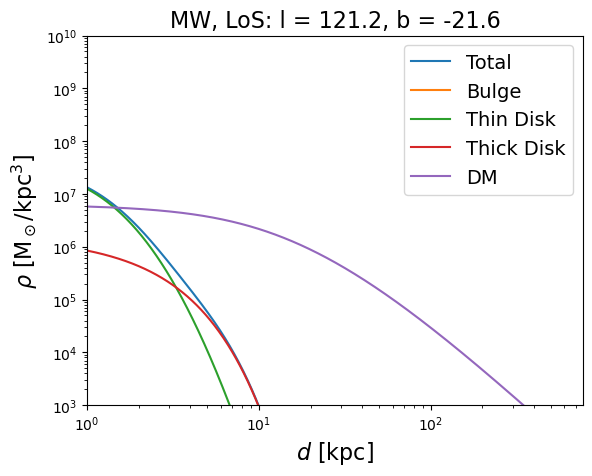

In [23]:
d_arr = np.logspace(np.log10(1), np.log10(ds), num=1000)
z_arr = [d * np.sin(np.deg2rad(b)) for d in d_arr]

# Calculate the density values for each component
rho_total_arr = [mw_model.density_stars(i) for i in d_arr]
rho_bulge_arr = [mw_model.rho_bulge(i) for i in d_arr]
rho_thin_arr = [mw_model.rho_thin(mw_model.dist_center(d_arr[i], l=l, b=b), z_arr[i]) for i in range(len(d_arr))]
rho_thick_arr = [mw_model.rho_thick(mw_model.dist_center(d_arr[i], l=l, b=b), z_arr[i]) for i in range(len(d_arr))]
rho_dm_arr = [mw_model.density_dm(d_arr[i]) for i in range(len(d_arr))]

plt.plot(d_arr, rho_total_arr, label="Total")
plt.plot(d_arr, rho_bulge_arr, label="Bulge")
plt.plot(d_arr, rho_thin_arr, label="Thin Disk")
plt.plot(d_arr, rho_thick_arr, label="Thick Disk")
plt.plot(d_arr, rho_dm_arr, label="DM")

plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('MW, LoS: l = {}, b = {}'.format(l, b), fontsize=16)
plt.legend(fontsize=14)

plt.yscale("log")
plt.xscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e3, 1e10)

plt.show()

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_63567/961728720.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


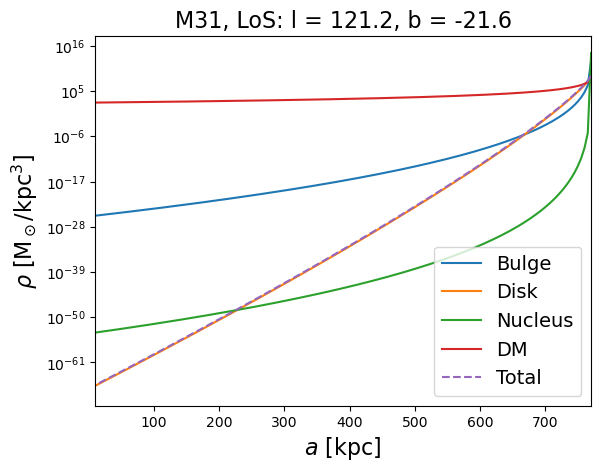

In [26]:
# Calculate the density values for each component
rho_total_arr = [m31_model.density_stars(d) for d in d_arr]
rho_bulge_arr = [m31_model.rho_bulge(m31_model.dist_center(d)) for d in d_arr]
rho_disk_arr = [m31_model.rho_disk(m31_model.dist_center(d)) for d in d_arr]
rho_nucleus_arr = [m31_model.rho_nucleus(m31_model.dist_center(d)) for d in d_arr]
rho_dm_arr = [m31_model.density_dm(d) for d in d_arr] # Assuming you have a method density_dm in M31Model

plt.plot(d_arr, rho_bulge_arr, label="Bulge")
plt.plot(d_arr, rho_disk_arr, label="Disk")
plt.plot(d_arr, rho_nucleus_arr, label="Nucleus")
plt.plot(d_arr, rho_dm_arr, label="DM")
plt.plot(d_arr, rho_total_arr, label="Total", ls="--")


plt.xlabel(r"$a$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('M31, LoS: l = {}, b = {}'.format(l,b), fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(1e1, ds)
# plt.xlim(765, 770)


plt.show()

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_5639/961728720.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


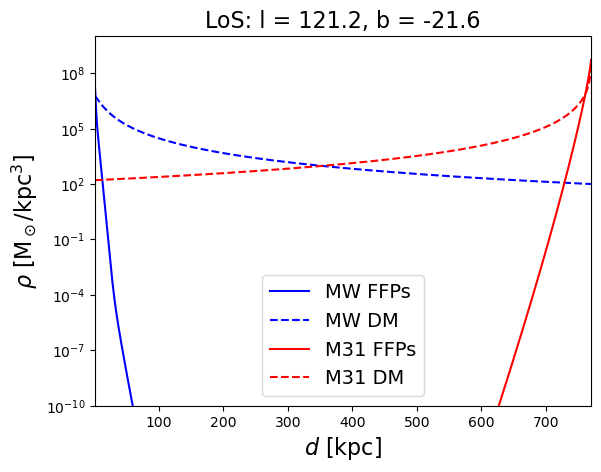

In [43]:
# Calculate the density values for each component using the methods from the classes
rho_ffp_mw = [mw_model.density_stars(d) for d in d_arr]
rho_ffp_m31 = [m31_model.density_stars(d) for d in d_arr]
rho_dm_mw = [mw_model.density_dm(d) for d in d_arr]
rho_dm_m31 = [m31_model.density_dm(d) for d in d_arr] # Assuming you have a method density_dm in M31Model

plt.plot(d_arr, rho_ffp_mw, label="MW FFPs", color="blue")
plt.plot(d_arr, rho_dm_mw, label="MW DM", color="blue", linestyle="--")
plt.plot(d_arr, rho_ffp_m31, label="M31 FFPs", color="red")
plt.plot(d_arr, rho_dm_m31, label="M31 DM", color="red", linestyle="--")

plt.xlabel(r"$d$ [kpc]", fontsize=16)
plt.ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
plt.title('LoS: l = {}, b = {}'.format(l, b), fontsize=16)

plt.legend(fontsize=14)

plt.yscale("log")
plt.xlim(1e0, ds)
plt.ylim(1e-10, 1e10)

plt.show()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()